# Notebook showing a fast and efficient way to load Sentinel-2 L1C data into xarray

In [1]:
import glob
import os
import numpy as np

import pandas as pd
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
from s2driver import driver_S2_SAFE as S2

import json
import requests
from datetime import datetime
from multiprocessing import Pool
import subprocess

from eoreader.keywords import CLEAN_OPTICAL
import s2driver

opj = os.path.join

s2driver.__version__

'1.0.4'

### Download L1C images through S3 protocol 

In [4]:

date_start='2020-01-01T00:00:00.000Z' 
date_end ='2023-12-31T00:00:00.000Z'
tiles=['30PYT']
cloud_cover_max = 60      


cmd = []
for tile in tiles:
    json = requests.get("https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {:.2f}) and contains(Name,'S2')".format(cloud_cover_max)+
                        " and  contains(Name,'MSIL1C') and  contains(Name,'"+tile+"')  and contains(Name,'_N05')"+
                        " and ContentDate/Start gt "+date_start+" and ContentDate/Start lt "+date_end+"&$orderby=ContentDate/Start&$top=1000").json()
    df = pd.DataFrame.from_dict(json['value'])
    
    
    
    for irow,info in df.iterrows():
        #print(info['Name'])
        date=datetime.strptime(info['Name'].split('_')[2],'%Y%m%dT%H%M%S')
        date.year
        odir = opj('/data/satellite/Sentinel-2/L1C/',tile,str(date.year),str(date.month).zfill(2),str(date.day).zfill(2))
        cmd.append('s3cmd -c ~/.s3cfg sync s3:/'+info['S3Path']+' '+odir)
#cmd

In [5]:
cmd

['s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/02/S2A_MSIL1C_20200102T102421_N0500_R065_T30PYT_20230424T205210.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/01/02',
 's3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/07/S2B_MSIL1C_20200107T102319_N0500_R065_T30PYT_20230421T010023.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/01/07',
 's3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/12/S2A_MSIL1C_20200112T102401_N0500_R065_T30PYT_20230423T065829.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/01/12',
 's3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/17/S2B_MSIL1C_20200117T102249_N0500_R065_T30PYT_20230510T221630.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/01/17',
 's3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/27/S2B_MSIL1C_20200127T102209_N0500_R065_T30PYT_20230427T173155.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/01/27',
 's3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C

In [6]:

def call(command):
    print(command)
    pipeline_out = subprocess.call(command, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, shell=True)
    return

ncore=4
with Pool(processes=ncore) as pool:
    pool.map(call, cmd)
    pool.close

s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/02/16/S2B_MSIL1C_20200216T102019_N0500_R065_T30PYT_20230625T112353.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/02/16s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/05/11/S2A_MSIL1C_20200511T102031_N0500_R065_T30PYT_20230507T021056.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/05/11s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/02/S2A_MSIL1C_20200102T102421_N0500_R065_T30PYT_20230424T205210.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/01/02s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/10/08/S2A_MSIL1C_20201008T102031_N0500_R065_T30PYT_20230308T052853.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/10/08



s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/05/16/S2B_MSIL1C_20200516T101559_N0500_R065_T30PYT_20230404T015330.SAFE /data/satellite/Sentinel-2/L1C/30PYT/2020/05/16
s3cmd -c ~/.s3cfg sync s3://eodata/Sentinel-2/MSI/L1C_N0500/2020/01/07/S2B_

In [16]:
import requests

url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products("+df.Id[0]+")/$value"

headers = {"Authorization": f"Bearer {access_token}"}

session = requests.Session()
session.headers.update(headers)
response = session.get(url, headers=headers, stream=True)

with open("product.zip", "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

### First, check the availbale bands:

In [3]:
s2driver.driver_S2_SAFE.INFO

bandId            0     1      2    3      4      5      6    7           8   \
ESA              B01   B02    B03  B04    B05    B06    B07  B08         B8A   
EOREADER          CA  BLUE  GREEN  RED  VRE_1  VRE_2  VRE_3  NIR  NARROW_NIR   
Wavelength (nm)  443   490    560  665    705    740    783  842         865   
Band width (nm)   20    65     35   30     15     15     20  115          20   
Resolution (m)    60    10     10   10     20     20     20   10          20   

bandId            9            10      11      12  
ESA              B09          B10     B11     B12  
EOREADER          WV  SWIR_CIRRUS  SWIR_1  SWIR_2  
Wavelength (nm)  945         1375    1610    2190  
Band width (nm)   20           30      90     180  
Resolution (m)    60           60      20      20

### Choose the bands to be loaded (fill the bandIds array up) and the resolution between 10, 20 and 60 m:

In [21]:
bandIds = [0,1,2,3,8,11,12]
resolution=20

### Create the s2driver objects for the selected images

In [22]:
l1c = S2.sentinel2_driver(imageSAFE,band_idx=bandIds,resolution=resolution)

### If you want to get the observation geometry bands only (i.e., sun and viewing zenith angle and relative azimuth)

In [6]:
%time %memit l1c.load_geom()

peak memory: 2542.18 MiB, increment: 2148.50 MiB
CPU times: user 40.3 s, sys: 24 s, total: 1min 4s
Wall time: 9.67 s


In [7]:
l1c.geom

<xarray.Dataset>
Dimensions:  (wl: 7, y: 1830, x: 1830)
Dimensions without coordinates: wl, y, x
Data variables:
    vza      (wl, y, x) float32 6.691 6.695 6.7 6.704 6.709 ... nan nan nan nan
    raa      (wl, y, x) float64 230.3 230.3 230.2 230.2 ... nan nan nan nan
    sza      (y, x) float64 22.94 22.94 22.94 22.94 ... 22.38 22.38 22.38 22.38

### If you want to get the radiometric bands only (i.e., top-of-atmosphere reflectance)

In [8]:
%time %memit l1c.load_bands()

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


peak memory: 4273.25 MiB, increment: 1895.39 MiB
CPU times: user 2min 20s, sys: 39.1 s, total: 2min 59s
Wall time: 20 s


In [24]:
from osgeo import gdal
print(gdal.GetCacheMax()*1e-9,gdal.GetCacheUsed()*1e-9)


3.358353612 1.3352806400000001


In [25]:

from eoreader.env_vars import USE_DASK

# Ensure EOReader uses dask if == 1
os.environ[USE_DASK] = "0"

### If you prefer to get the geometry and radiometric bands simultaneously 

In [26]:
%time %memit l1c.load_product()

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


peak memory: 14234.12 MiB, increment: 5323.84 MiB
CPU times: user 54 s, sys: 17.7 s, total: 1min 11s
Wall time: 33.2 s


In [27]:

from eoreader.env_vars import USE_DASK

# Ensure EOReader uses dask if == 1
os.environ[USE_DASK] = "1"
%time %memit l1c.load_product()

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


peak memory: 14174.39 MiB, increment: 5298.73 MiB
CPU times: user 1min 3s, sys: 33.9 s, total: 1min 37s
Wall time: 31.9 s


In [29]:
from eoreader.keywords import CLEAN_OPTICAL
from eoreader.products import CleanMethod
os.environ[USE_DASK] = "0"
%time %memit l1c.load_product( **{CLEAN_OPTICAL: CleanMethod.RAW})

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


peak memory: 14363.34 MiB, increment: 5353.54 MiB
CPU times: user 56 s, sys: 17.3 s, total: 1min 13s
Wall time: 32 s


In [30]:
os.environ[USE_DASK] = "0"
%time %memit l1c.load_product( **{CLEAN_OPTICAL: CleanMethod.NODATA})

/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


peak memory: 14361.00 MiB, increment: 5351.04 MiB
CPU times: user 55.4 s, sys: 16.9 s, total: 1min 12s
Wall time: 33.3 s


In [13]:
l1c.prod

<xarray.Dataset>
Dimensions:      (x: 1830, y: 1830, wl: 7, wl_hr: 1950)
Coordinates:
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 8e+05 8e+05 7.999e+05 ... 6.903e+05 6.903e+05
    spatial_ref  int64 0
  * wl           (wl) object 443 490 560 665 865 1610 2190
  * wl_hr        (wl_hr) int64 400 401 402 403 404 ... 2345 2346 2347 2348 2349
Data variables:
    bands        (wl, y, x) float32 0.578 0.5742 0.5532 0.5474 ... nan nan nan
    SRF          (wl, wl_hr) float64 nan nan nan nan nan ... nan nan nan nan nan
    wl_true      (wl) float64 442.2 492.4 558.9 664.9 864.0 1.61e+03 2.186e+03
    vza          (wl, y, x) float32 6.691 6.695 6.7 6.704 ... nan nan nan nan
    raa          (wl, y, x) float64 230.3 230.3 230.2 230.2 ... nan nan nan nan
    sza          (y, x) float64 22.94 22.94 22.94 22.94 ... 22.38 22.38 22.38
Attributes: (12/47)
    long_name:                           CA BLUE GREEN RED NARROW_NIR SWIR_1 ...
    constellation:                       Sentinel-2
    constellation_id:                    S2
    product_path:                        /data/satellite/S2/cnes/S2B_MSIL1C_2...
    product_name:                        S2B_MSIL1C_20220811T100559_N0400_R02...
    product_filename:                    S2B_MSIL1C_20220811T100559_N0400_R02...
    ...                                  ...
    SENSOR_QUALITY:                      PASSED
    SPECIAL_VALUE_NODATA:                0
    SPECIAL_VALUE_SATURATED:             65535
    satellite:                           S2B
    solar_irradiance:                    [1874.3  1959.75 1824.93 1512.79 142...
    solar_irradiance_unit:               W/m²/µm

### From that stage you can check some metadata such as crs or spectral response functions:

EPSG:32631


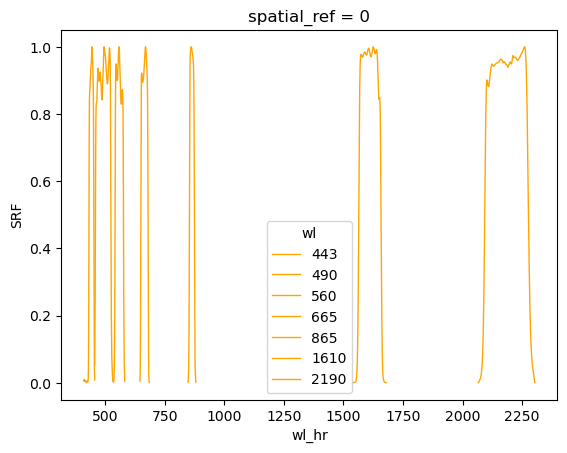

In [14]:
print(l1c.prod.rio.crs)
l1c.prod.SRF.plot(x='wl_hr',hue='wl',color='orange',lw=1)

# Plotting section
The MSI-Sentinel-2 instrument is composed of 12 detectors staggered in two different rows making a "switch" in viewng geometries along the image especially for the azimuth values. Here, we plot the solar and viewing zenith angles as well as the relative azimuth between Sun and sensor directions.
The sun viewing angle (SZA) is common to all the spectral bands.

The sensor angles are dependent on the spectral band considered, here are the viewing zenith angle (VZA) and the relative azimuth (RAZI) for the bands loaded in the S2 object.
## VZA

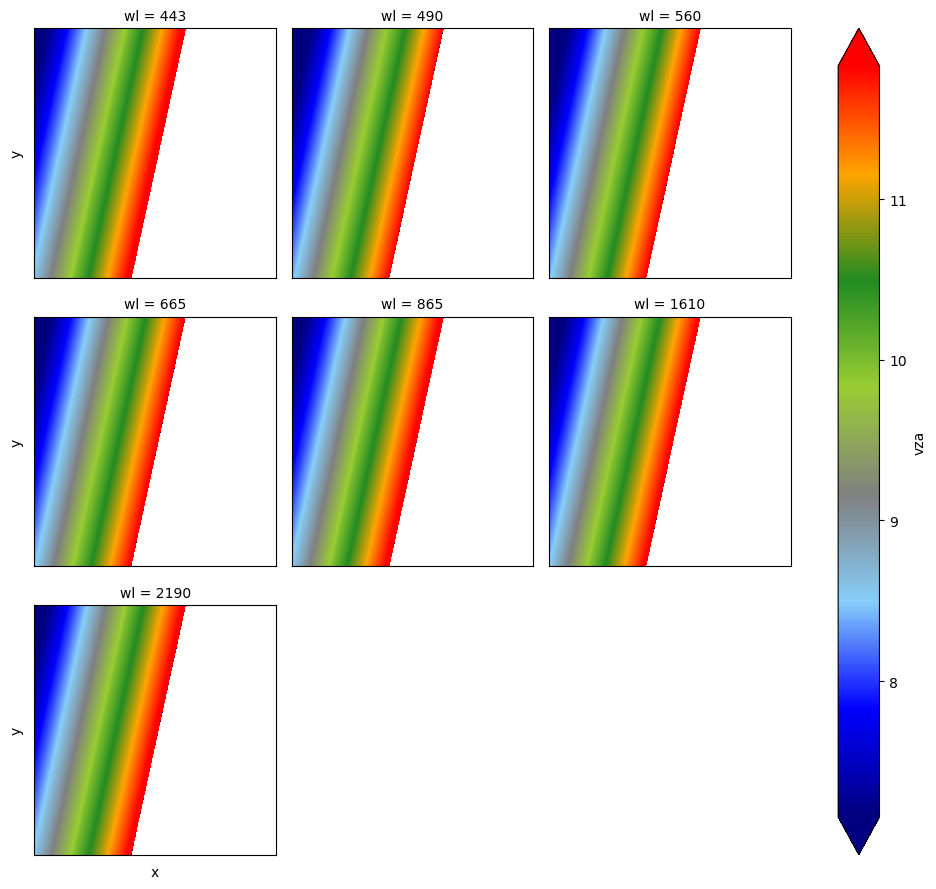

In [15]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("",['navy', "blue", 'lightskyblue', 'gray', 'yellowgreen', 'forestgreen', 'orange', 'red'])
fig = l1c.prod.vza.plot.imshow(col='wl', cmap=cmap, col_wrap=3,  robust=True,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

## RAZI

In [ ]:
fig = l1c.prod.raa.plot.imshow(col='wl', cmap=cmap, col_wrap=3, aspect=1, robust=True,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

Check the difference between two bands (e.g., B02-B8A)

In [31]:
param='vza'
diff_vza = l1c.prod[param].sel(wl=490)-l1c.prod[param].sel(wl=865)
param='raa'
diff_raa = l1c.prod[param].sel(wl=490)-l1c.prod[param].sel(wl=865)


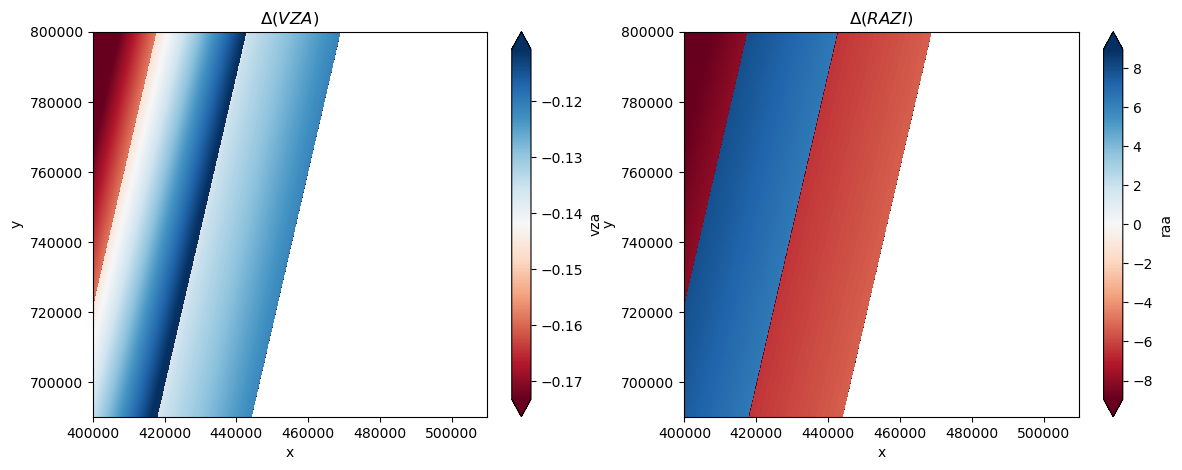

In [32]:
fig, axs = plt.subplots(ncols=2,figsize=(14,5))
diff_vza.plot.imshow(ax=axs[0],cmap=plt.cm.RdBu, robust=True)
axs[0].set_title('$\Delta (VZA)$')
diff_raa.plot.imshow(ax=axs[1],cmap=plt.cm.RdBu, robust=True)
axs[1].set_title('$\Delta (RAZI)$')
plt.show()

The reflectance data can also be easily plotted:

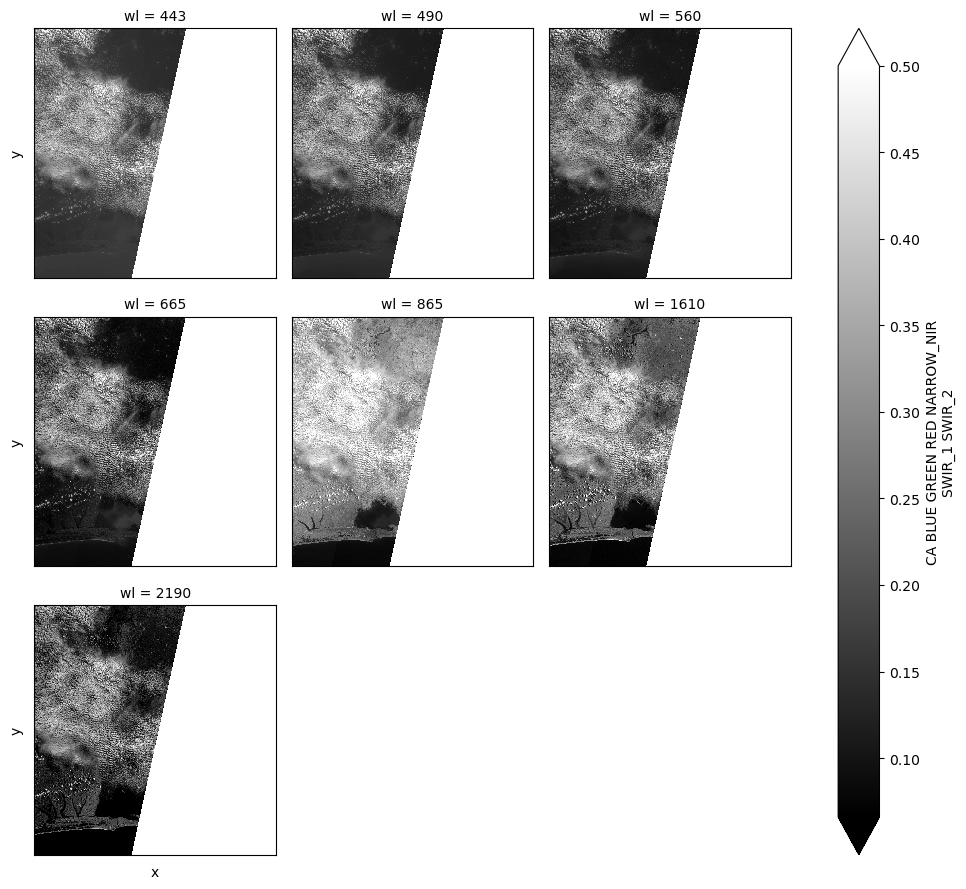

In [34]:

p = l1c.prod.bands.plot.imshow(col='wl', col_wrap=3,  vmax=0.5, robust=True, cmap=plt.cm.binary_r,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

For nicer plotting we use cartopy and argument 'projection' of matplotlib

In [27]:
import cartopy.crs as ccrs
str_epsg = str(l1c.epsg)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

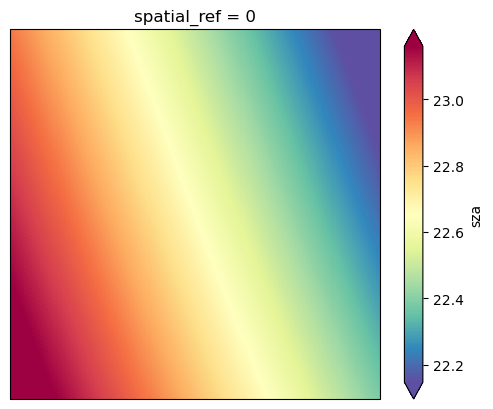

In [28]:
coarsening = 10
p = l1c.prod.sza[::coarsening, ::coarsening].plot.imshow(subplot_kws=dict(projection= proj), robust=True, cmap=plt.cm.Spectral_r)

And the RGB image:

In [47]:
# Get geographic projection and bounds
extent = l1c.extent

bounds = extent.bounds
extent_val = [bounds.minx[0], bounds.maxx[0]-40000, bounds.miny[0], bounds.maxy[0]-50000]
#extent_val = [bounds.minx[0], bounds.maxx[0], bounds.miny[0], bounds.maxy[0]]


Text(0.5, 1.0, '')

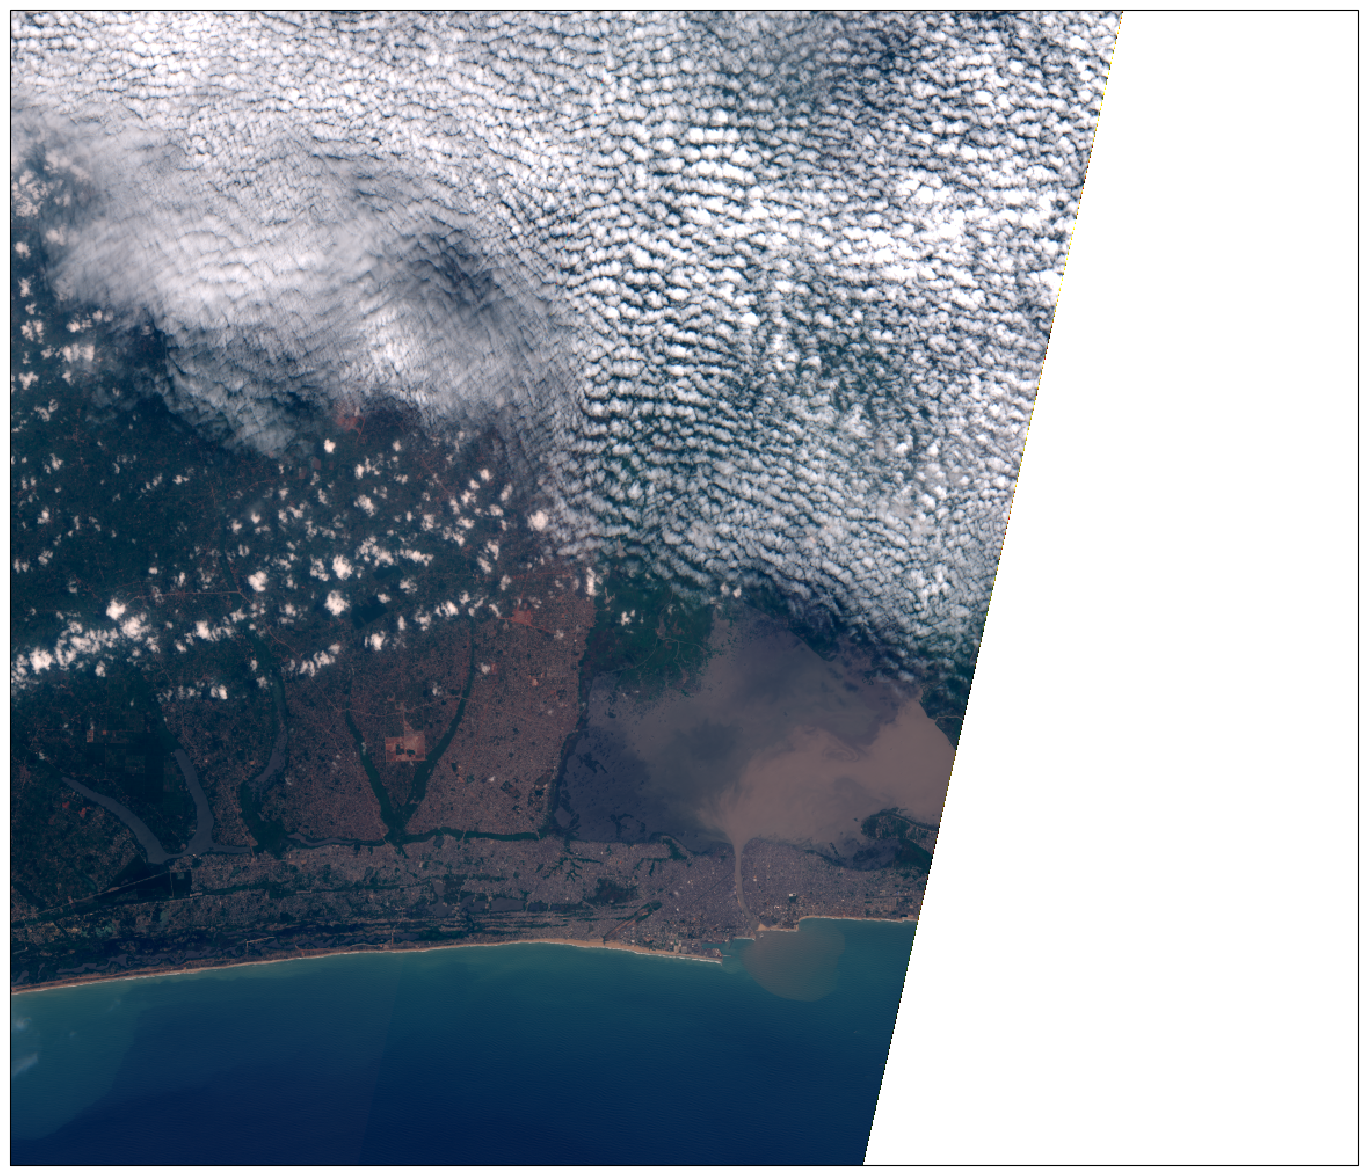

In [48]:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent(extent_val, proj)
coarsening=1
brightness_factor = 3.5
(l1c.prod.bands[:, ::coarsening, ::coarsening].sel(wl=[665,560,490])**0.5**brightness_factor
).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection= proj))
ax.set_title('')

## Example of exploiation: compute NDWI for water pixel masking

In [60]:
# Compute NDWI
green = l1c.prod.bands.sel(wl=565,method='nearest')
nir = l1c.prod.bands.sel(wl=865,method='nearest')
ndwi = (green - nir) / (green + nir)


def water_mask(ndwi, threshold=0):
    water = xr.where(ndwi > threshold, 1, 0)
    return water.where(~np.isnan(ndwi))


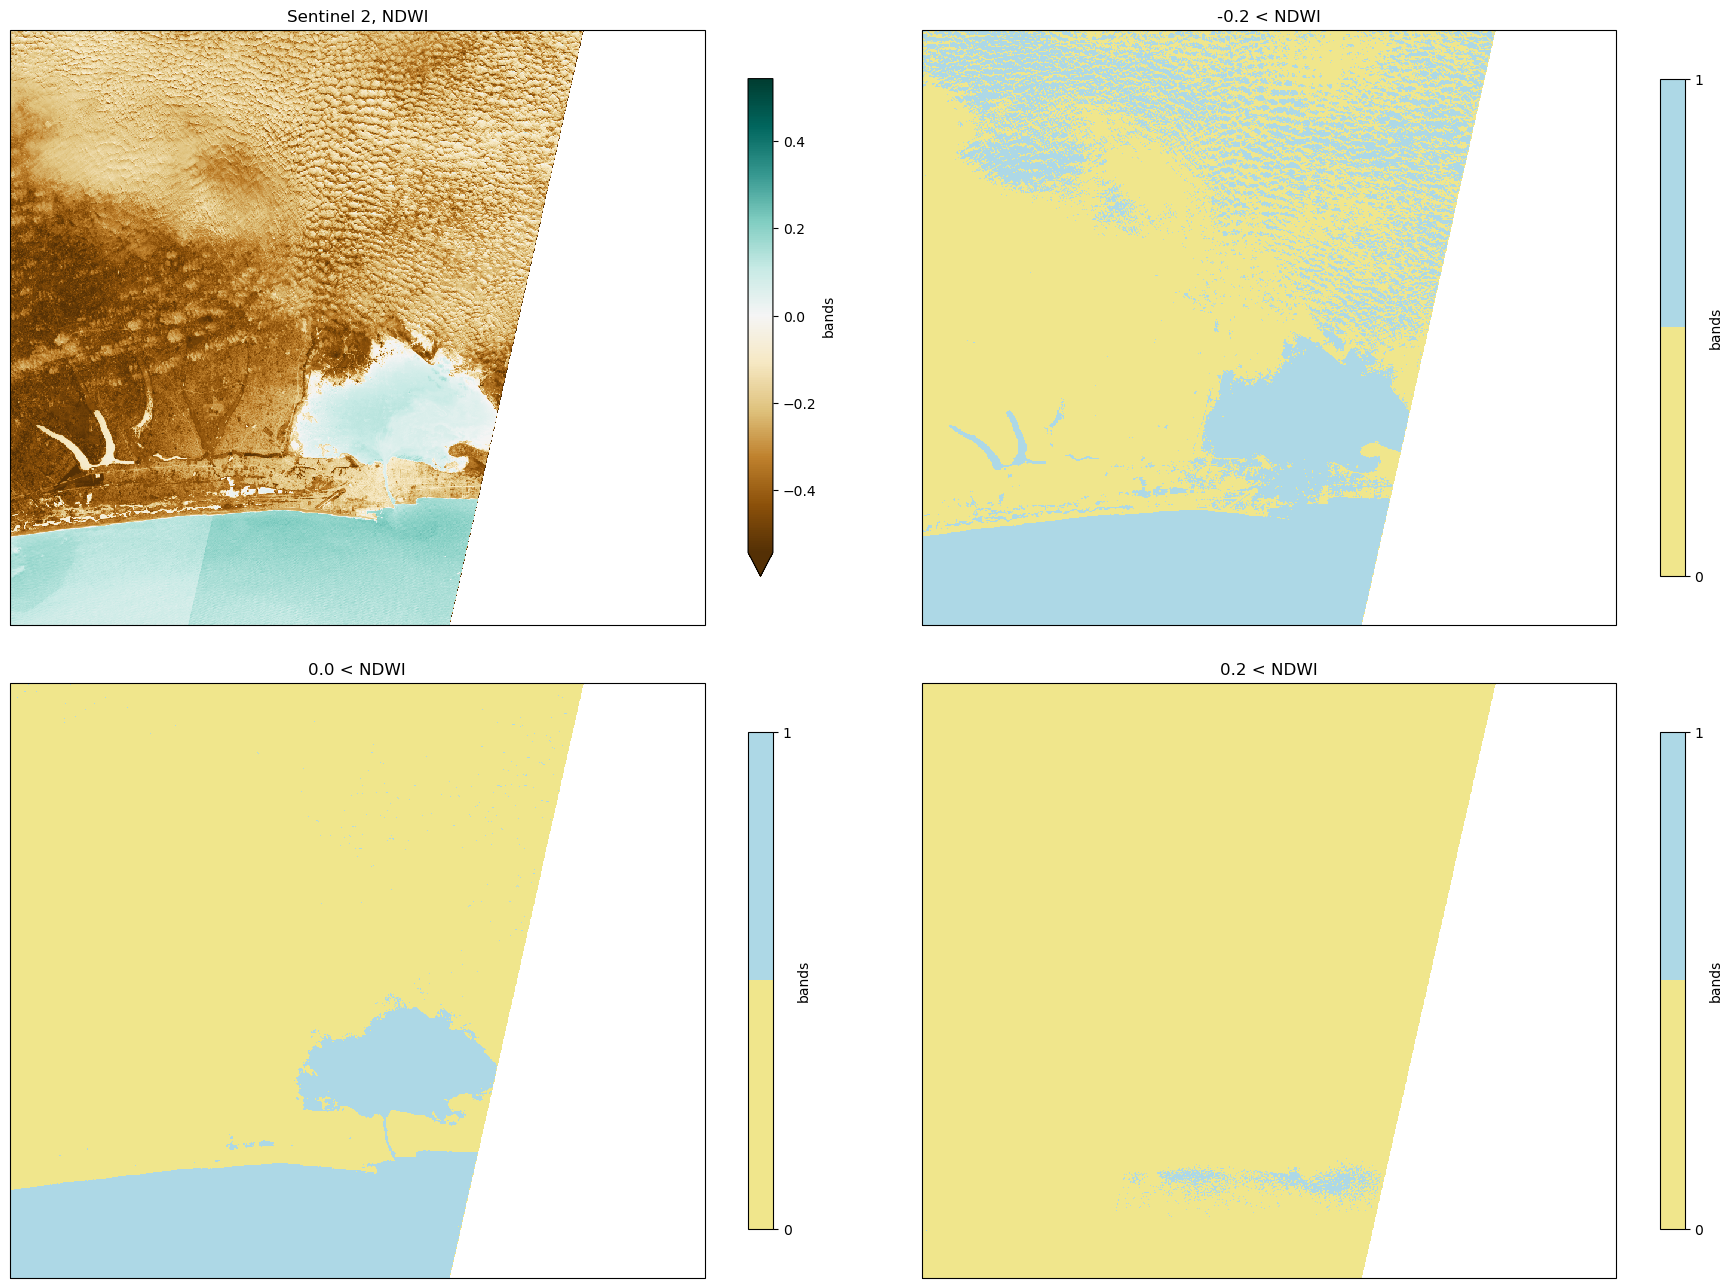

In [61]:
#coarsening to save memory and speed
coarsening=1
ndwi_ = ndwi[::coarsening, ::coarsening]


# binary cmap
bcmap = ListedColormap(['khaki', 'lightblue'])


def water_mask(ndwi, threshold=0):
    water = xr.where(ndwi > threshold, 1, 0)
    return water.where(~np.isnan(ndwi))

def plot_water_mask(ndwi,ax,threshold=0):
    water = water_mask(ndwi, threshold)
    ax.set_extent(extent_val, proj)
    water.plot.imshow(extent=extent_val, transform=proj, cmap=bcmap,
                                  cbar_kwargs={'ticks': [0, 1], 'shrink': shrink})
    ax.set_title(str(threshold)+' < NDWI')

fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.99,
                    hspace=0.05, wspace=0.05)
shrink = 0.8
    
ax = plt.subplot(2, 2, 1, projection=proj)
ax.set_extent(extent_val, proj)
fig = ndwi[::coarsening, ::coarsening].plot.imshow(extent=extent_val, transform=proj, cmap=plt.cm.BrBG, robust=True,
                                   cbar_kwargs={'shrink': shrink})
# axes.coastlines(resolution='10m',linewidth=1)
ax.set_title('Sentinel 2, NDWI')

for i,threshold in enumerate([-0.2,0.,0.2]):
    ax = plt.subplot(2, 2, i+2, projection=proj)
    plot_water_mask(ndwi_,ax,threshold=threshold)

plt.show()
